# Importing Libraries

We start by installing all the required libraries like tensorflow, keras, numpy, matplotlib,etc and importing them.

After that we import the CIFAR 10 dataset from the tensorflow.keras.datasets  library.


In [ ]:
import keras
from keras import layers
import torch
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Now we can begin exploring the data a bit. We are working with a dataset that consists of 10,000 32x32 color images and their corresponding labels. The images are classified into 10 categories. The categories are represented simply by numbers 0 to 9. We can plot the images in grid to see what we are working with.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


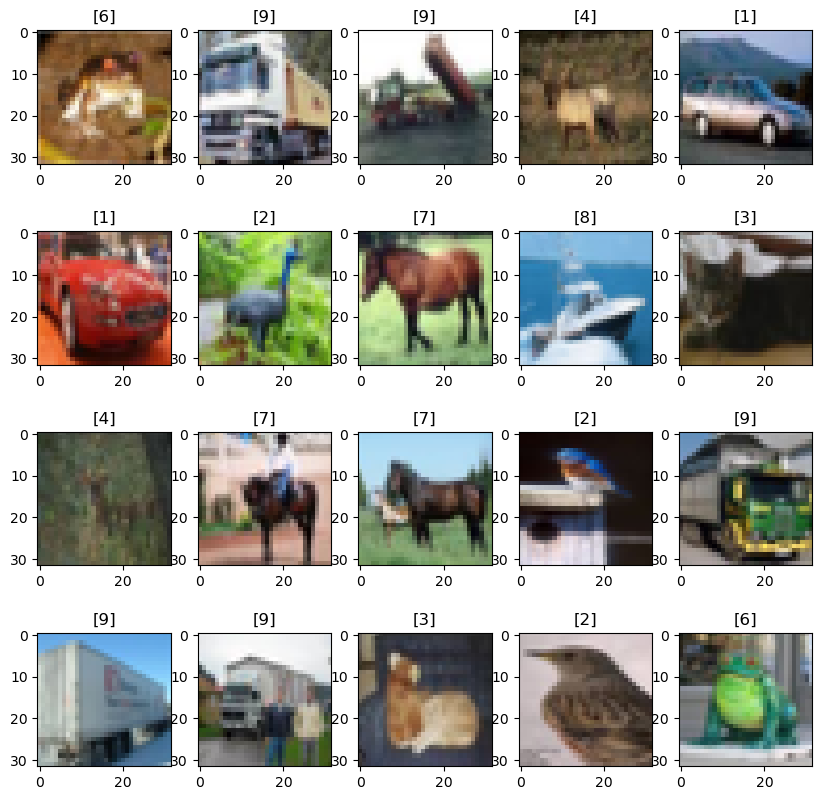

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])
plt.show()

# Determining what class number corresponds to what object

While this step is not required to train the model, we can try to come up with word labels for the categories. This will help us later when we are evaluating different models with the help of confusion matrix. Using word labels instead of numbers in confusion matrix will reveal if model has any difficulty prediciting labels for a particular category, or is getting confused by two different categories that are similar.

While we can take some guess from the examples show, its not clear exactly which objects these class number represent. Class 6 is difficult to understand, and Class 5 is missing entirely.

We can try to find multiple examples from each class to determine the class label.

Steps
1. Find few images from each class.
2. Plot images from all class with their class number.
3. Examine the images and decide a label to assign to the class.

We chose to display 4 images from each class. We made use of the plt.subplot function.

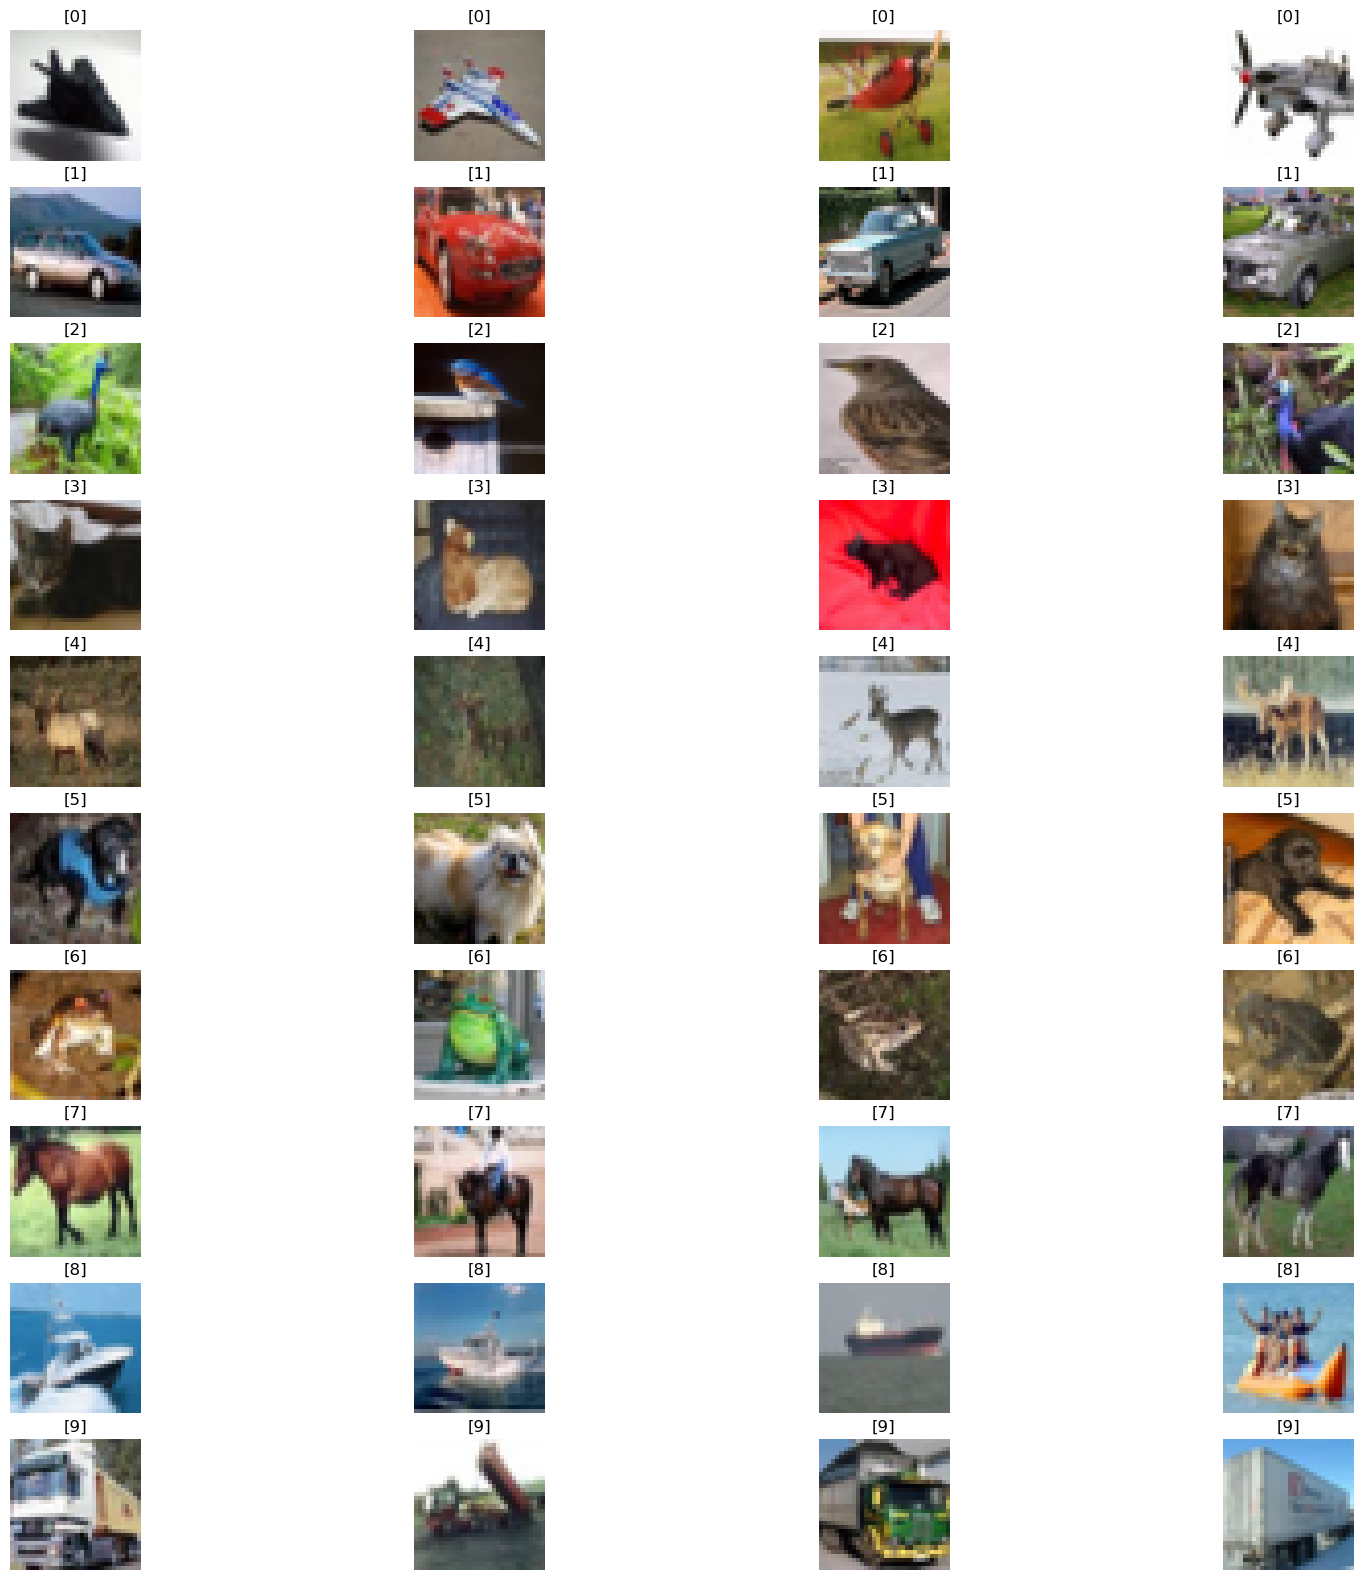

In [ ]:
class_img = 0 # Keep count of current class
count_j = 0 # Keep count of total images in grid
all_class = [] # Array to store Indexes of class

while count_j < 40:                         # Find 4 examples from 10 classes, 40 Total
    i = 0                                   # Index var
    count = 0                               # Init var to store number of examples found
    while count < 4:                        # Find 4 example of current class
        if train_labels[i] == class_img:
            count += 1                      # Update number of examples found
            all_class.append(i)             # Store the index

        i += 1

    class_img += 1                # Move to next class
    count_j += 4                  # Update with current count of imgs from all classes

plt.figure(figsize=(20, 20))

for plt_idx, img_idx in enumerate(all_class):                   # Iterate on Index List
    plt.subplot(10, 4, plt_idx + 1)     # Set Rows = Num of Class,Col = Num of Examples
    plt.axis('off')
    plt.imshow(train_images[img_idx])
    plt.title(train_labels[img_idx])
plt.show()

The categories can therefore be inferred as 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

# Transforming Data

To improve the prediction ability of the model we can do some very simple things like applying simple transformations to part of the dataset. These simple transformations include rotating the images, flipping the images horizontally, cropping off part of the image. This can also help us increase the amount of training data, by creating new images from the existing data.

Right now, nearly all images have the subject in center, in proper orientation. If a model is trained on such data, it will have trouble classifying the image if the subject is not centered or if the image is flipped or rotated a bit. The model trained on augmented data will therefore be less sensitive to specific orientation of the training images and will be forced to learn more generalised features.

We also need to understand that if we simply give color images to the model, it will have trouble categorizing same objects of different color. A cat can have dark fur, or light fur, or the photo of the cat can be taken in different lighting conditions. Same with cars, cars can come in a many color combinations. We want the model to extract features that are based on the shape of the objects and not on the color.If we normalize each of the rgb channels of the training images and also put the test images through same process, we can get a model that is not dependent on color to classify the images into the categories.

The data being in tensor format is of huge help to use since we can easily extract the individual color channels from the tensors very easily and perform the calculations very fast. We can easily calculate the mean and std of each color channels and use that to normalize data to mean of zero and std of 1.


In [ ]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

imgs = np.concatenate([train_images, test_images], axis=0)

mean_r = imgs[:, :, :, 0].mean()
mean_g = imgs[:, :, :, 1].mean()
mean_b = imgs[:, :, :, 2].mean()

std_r = imgs[:, :, :, 0].std()
std_g = imgs[:, :, :, 1].std()
std_b = imgs[:, :, :, 2].std()

# ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

train_images[:, :, :, 0] = (train_images[:, :, :, 0] - mean_r) / std_r
train_images[:, :, :, 1] = (train_images[:, :, :, 1] - mean_g) / std_g
train_images[:, :, :, 2] = (train_images[:, :, :, 2] - mean_b) / std_b

test_images[:, :, :, 0] = (test_images[:, :, :, 0] - mean_r) / std_r
test_images[:, :, :, 1] = (test_images[:, :, :, 1] - mean_g) / std_g
test_images[:, :, :, 2] = (test_images[:, :, :, 2] - mean_b) / std_b

# ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# Create new image with transformation
datagen = ImageDataGenerator(
    rotation_range=15,        # Random rotation
    width_shift_range=0.1,    # Random horizontal shift
    height_shift_range=0.1,   # Random vertical shift
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill mode
)
datagen.fit(train_images)

# ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

# Defining commonly used Functions

Its good practice to write down functions for task that we intend to perform repeatedly. We will largely be doing the same set of tasks to evaluate a model, including providing the same data. The only things that we want to experiment with are the layer combinations and model parameters like number of epochs, or using a different loss or activation function, changing width and depth of the network. So after applying .compile function to the model, we will simply call these functions to handle visualing the model, providing data to the model, storing the results, and generating classification reports and creating confusion matrix.


In [ ]:
model_plot_number = 1

def plot_and_display_model(model, filename='model', figsize=(10, 10)):
    global model_plot_number
    filename = 'model'+str(model_plot_number)+'.png'
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    image = plt.imread(filename)
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    model_plot_number += 1

def evaluate_model(model, train_images, train_labels, test_images, test_labels, epoch):

    history = model.fit(train_images, train_labels, epochs=epoch,
                     validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'Test accuracy: {test_acc}')
    return test_loss, test_acc, history

def plot_training_history(history):

    plt.figure(figsize=(12, 4))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def evaluate_model_performance(model, test_images, test_labels):

    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    report = classification_report(y_true, y_pred_classes, target_names=
    ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    print(report)

    return y_true, y_pred_classes

def plot_confusion_matrix(y_true, y_pred_classes):

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
                yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def Model_Evaluation(model, train_images, train_labels, test_images, test_labels, epoch):
    plot_and_display_model(model, filename='model', figsize=(10, 10))
    test_loss, test_acc, history = evaluate_model(model, train_images, train_labels,
                                                  test_images, test_labels ,epoch )
    plot_training_history(history)
    y_true, y_pred_classes = evaluate_model_performance(model, test_images, test_labels)
    plot_confusion_matrix(y_true, y_pred_classes)

def ModelEval(model, epoch, one_hot_encoded=1):

    if one_hot_encoded == 1:
        Model_Evaluation(model, train_images, train_labels_cat, test_images, test_labels_cat, epoch)
    else:
        Model_Evaluation(model, train_images, train_labels, test_images, test_labels, epoch)


# Trying Out Different Layer Combinations


Now evaluating the model is a simple task of passing to ModelEval function the model name, number of epochs and variable to indicate whether the model should use the labels as is or use the one hot encoded one.

## Deciding layers

Lets talk a bit about the reasons we chose to include convulutional and pooling layers. Convolution is a process that involves sliding a filter called a kernel over the image to highlight certain features present in the image. Kernel is essentially a matrix of numbers. The numbers we choose will transform the image in some way. We can sharpen or blur the image using this process. If we have a kernel that has positive values on left that decreases to zero in the center of the kernel and decreases to negative value in the right side, the transformation in the image will highlight the edges in the image. So this processes is very important if we want to extract the outlines or silhouette of the objects in the model. The result is that we get a more generalised image which is what we need to build a more accurate model. There are many parameters that we can adjust in kernel like the size, the number of pixels it will move after a operation (stride) or if we want it to be more spread out (dialation). Dilated convolutions (atrous convolutions)  increases the receptive field of the convolutional layers without increasing the number of parameters or the amount of computation.


Pooling layers essentially reduce the image, which helps in computation and also helps the model understand higher level features. Pooling means in the next layer, using a kernel of same size we can scan a larger position of image. So for example, instead of just being able to scan the wheels of a car, we can scan the entire car. Using convolution in conjunction with pooling can help reduce the size and complexity of the nn required to classify the images. Padding will insert additional row and column of 0s outside the matrix so each value will be sampled same number of times, to ensure outer/border pixels of image are not undevalued. If we want to build very deep networks, then it possible that after a couple of convolutions and pooling layers the images will be too small and in this case padding the images will prevent it from becoming too small and ususable.




# Linear and Sigmoid

The first model is a simple model with just 3 pairs of convolution and pooling layers, followed by flatten and dense layers.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


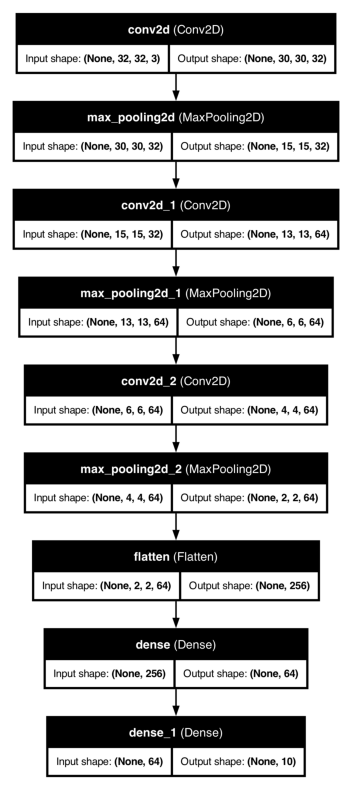

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4203 - loss: 0.2627 - val_accuracy: 0.6026 - val_loss: 0.2009
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6140 - loss: 0.1959 - val_accuracy: 0.6298 - val_loss: 0.1914
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6602 - loss: 0.1782 - val_accuracy: 0.6270 - val_loss: 0.1908
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6897 - loss: 0.1667 - val_accuracy: 0.6324 - val_loss: 0.1896
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7123 - loss: 0.1585 - val_accuracy: 0.6643 - val_loss: 0.1782
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7287 - loss: 0.1514 - val_accuracy: 0.6636 - val_loss: 0.1791
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7424 - loss: 0.1456 - val_accuracy: 0.6695 - val_loss: 0.1816
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7533 - lo

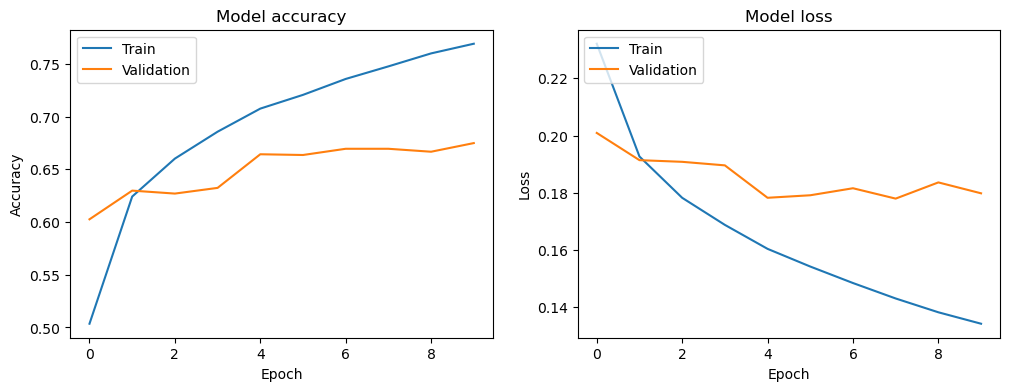

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

    airplane       0.73      0.67      0.70      1000
  automobile       0.86      0.76      0.81      1000
        bird       0.53      0.62      0.57      1000
         cat       0.48      0.53      0.50      1000
        deer       0.63      0.66      0.64      1000
         dog       0.63      0.55      0.59      1000
        frog       0.80      0.68      0.74      1000
       horse       0.71      0.69      0.70      1000
        ship       0.76      0.79      0.77      1000
       truck       0.70      0.81      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.68     10000
weighted avg       0.68      0.67      0.68     10000



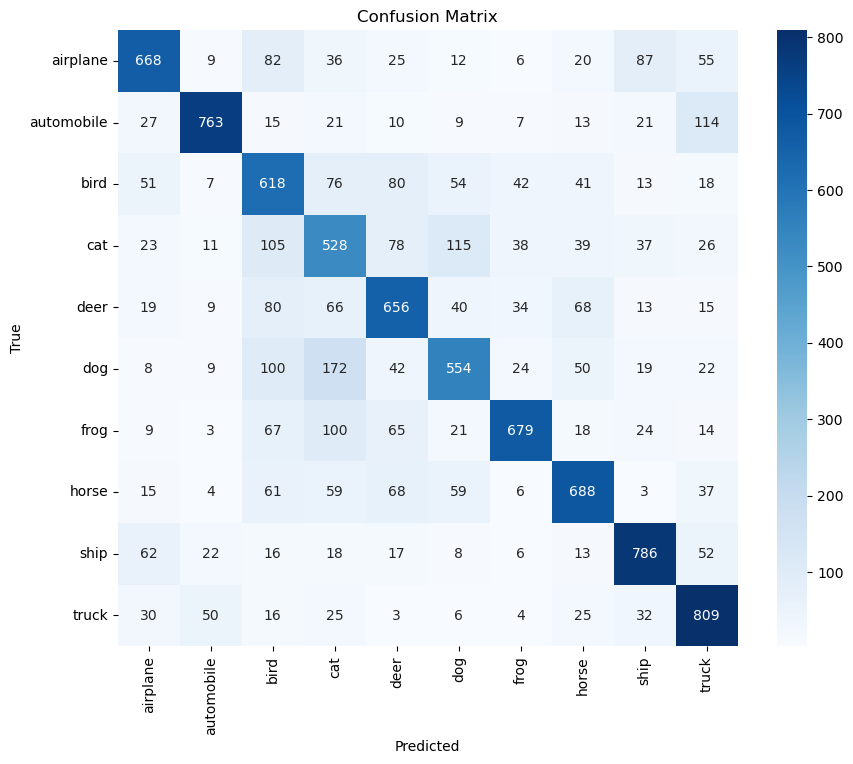

In [ ]:
modellinsig = models.Sequential()

modellinsig.add(layers.Conv2D(32, (3, 3), activation='linear', input_shape=(32, 32, 3)))
modellinsig.add(layers.MaxPooling2D((2, 2)))

modellinsig.add(layers.Conv2D(64, (3, 3), activation='linear'))
modellinsig.add(layers.MaxPooling2D((2, 2)))

modellinsig.add(layers.Conv2D(64, (3, 3), activation='linear'))
modellinsig.add(layers.MaxPooling2D((2, 2)))

modellinsig.add(layers.Flatten())
modellinsig.add(layers.Dense(64, activation='linear'))
modellinsig.add(layers.Dense(10, activation='sigmoid'))

modellinsig.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

ModelEval(modellinsig, 10, 1)

Model 1 only gets a accuracy of 67.5%. Its easy to surpass this by trying out different combinations of activation functions.

# Change Activations to Relu and Sigmoid

The only change here is that instead of linear, relu function is used in convolution. ReLU is a non linear function that has potential to learn complex patterns. Categorical cross entropy loss is used instead of binary cross entropy.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


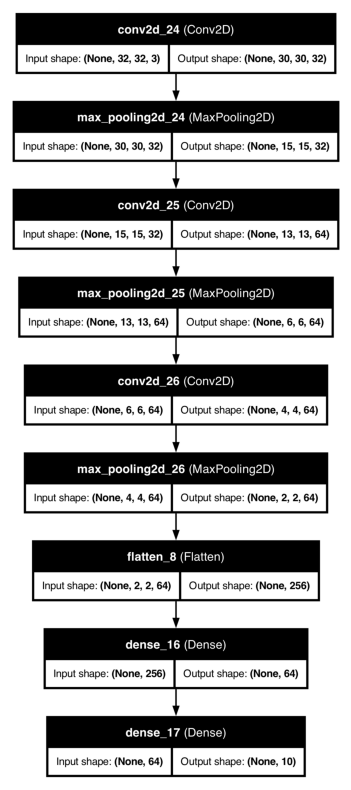

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3906 - loss: 1.6568 - val_accuracy: 0.5802 - val_loss: 1.1872
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6204 - loss: 1.0837 - val_accuracy: 0.6303 - val_loss: 1.0663
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6834 - loss: 0.9115 - val_accuracy: 0.6735 - val_loss: 0.9610
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7202 - loss: 0.7964 - val_accuracy: 0.7092 - val_loss: 0.8447
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7441 - loss: 0.7288 - val_accuracy: 0.7011 - val_loss: 0.8825
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7682 - loss: 0.6663 - val_accuracy: 0.7088 - val_loss: 0.8577
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7811 - loss: 0.6153 - val_accuracy: 0.7181 - val_loss: 0.8388
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8016 -

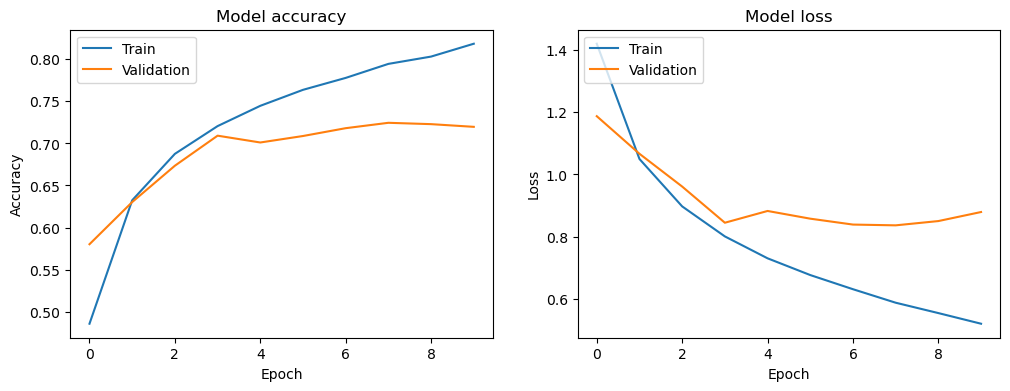

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    airplane       0.70      0.80      0.75      1000
  automobile       0.83      0.87      0.85      1000
        bird       0.62      0.67      0.65      1000
         cat       0.50      0.61      0.55      1000
        deer       0.71      0.63      0.67      1000
         dog       0.71      0.54      0.61      1000
        frog       0.80      0.77      0.79      1000
       horse       0.79      0.68      0.73      1000
        ship       0.82      0.82      0.82      1000
       truck       0.77      0.81      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



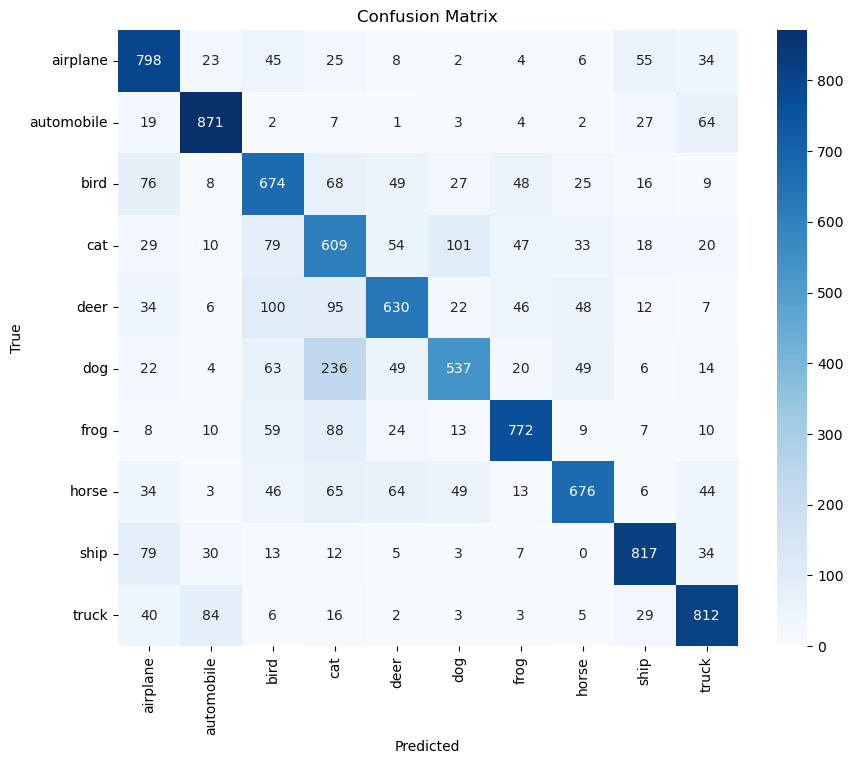

In [ ]:
model_re_sig = models.Sequential()

model_re_sig.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_re_sig.add(layers.MaxPooling2D((2, 2)))

model_re_sig.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_re_sig.add(layers.MaxPooling2D((2, 2)))

model_re_sig.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_re_sig.add(layers.MaxPooling2D((2, 2)))

model_re_sig.add(layers.Flatten())
model_re_sig.add(layers.Dense(64, activation='relu'))
model_re_sig.add(layers.Dense(10, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'

model_re_sig.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

ModelEval(model_re_sig, 10, 1)

A huge jump in accuracy is observed at 71.9%.

# Change Activations to Relu and Softmax

Next change is use of softmax activation function in the final dense layer, because it has potential to be better than sigmmoid in multi class classification problem.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


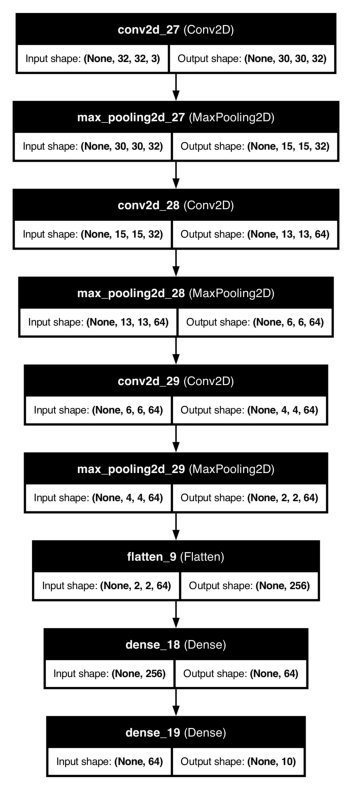

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.4025 - loss: 1.6422 - val_accuracy: 0.5819 - val_loss: 1.1590
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6116 - loss: 1.0977 - val_accuracy: 0.6531 - val_loss: 0.9860
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6823 - loss: 0.9065 - val_accuracy: 0.6891 - val_loss: 0.8919
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7177 - loss: 0.8060 - val_accuracy: 0.7115 - val_loss: 0.8368
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7471 - loss: 0.7253 - val_accuracy: 0.7084 - val_loss: 0.8373
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7726 - loss: 0.6519 - val_accuracy: 0.7160 - val_loss: 0.8330
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7899 - loss: 0.6027 - val_accuracy: 0.7273 - val_loss: 0.8062
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8090 -

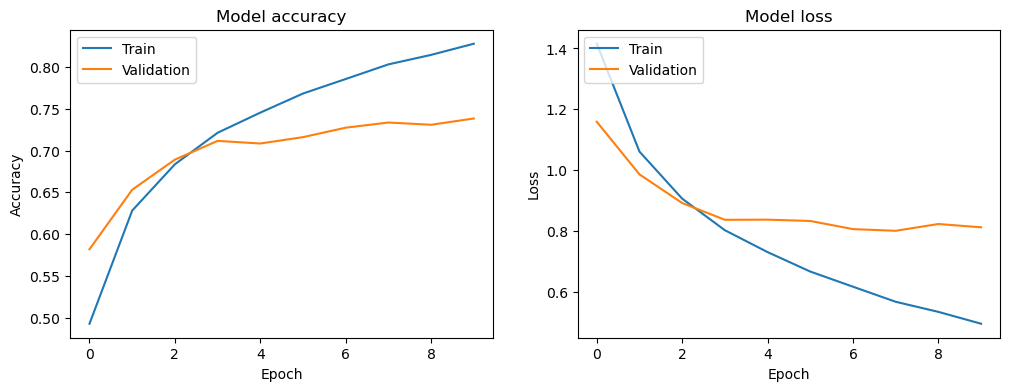

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    airplane       0.76      0.75      0.76      1000
  automobile       0.87      0.84      0.86      1000
        bird       0.62      0.68      0.65      1000
         cat       0.54      0.61      0.57      1000
        deer       0.67      0.71      0.69      1000
         dog       0.71      0.59      0.65      1000
        frog       0.82      0.80      0.81      1000
       horse       0.80      0.72      0.76      1000
        ship       0.86      0.82      0.84      1000
       truck       0.77      0.85      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



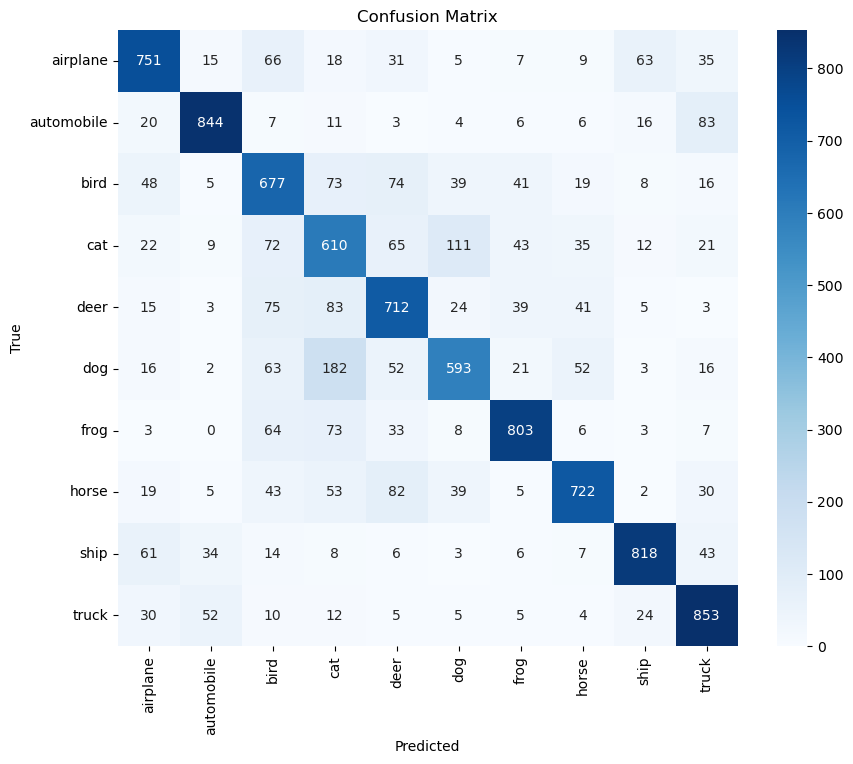

In [ ]:
model_re_sft = models.Sequential()

model_re_sft.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_re_sft.add(layers.MaxPooling2D((2, 2)))

model_re_sft.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_re_sft.add(layers.MaxPooling2D((2, 2)))

model_re_sft.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_re_sft.add(layers.MaxPooling2D((2, 2)))

model_re_sft.add(layers.Flatten())
model_re_sft.add(layers.Dense(64, activation='relu'))
model_re_sft.add(layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'

model_re_sft.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

ModelEval(model_re_sft, 10, 1)

Slight improve is seen in accuracy at 73.8%

# Add More Layers and include Dropout Layer

More layers can mean more capacity to learn intricate features, so the next model will have 4 pairs of convolution and pooling layers. Added layers necessitate the use of padding to ensure the image is not getting too small.
Dropout layer is added to network to introduce regularization.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


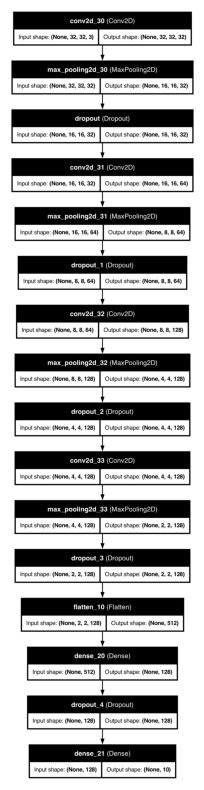

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.3471 - loss: 1.7541 - val_accuracy: 0.6086 - val_loss: 1.1071
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.6013 - loss: 1.1233 - val_accuracy: 0.6678 - val_loss: 0.9313
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.6674 - loss: 0.9448 - val_accuracy: 0.7175 - val_loss: 0.8152
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7038 - loss: 0.8552 - val_accuracy: 0.7314 - val_loss: 0.7705
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.7234 - loss: 0.7946 - val_accuracy: 0.7469 - val_loss: 0.7300
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.7388 - loss: 0.7524 - val_accuracy: 0.7568 - val_loss: 0.7198
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.7523 - loss: 0.7157 - val_accuracy: 0.7550 - val_loss: 0.7178
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7595 -

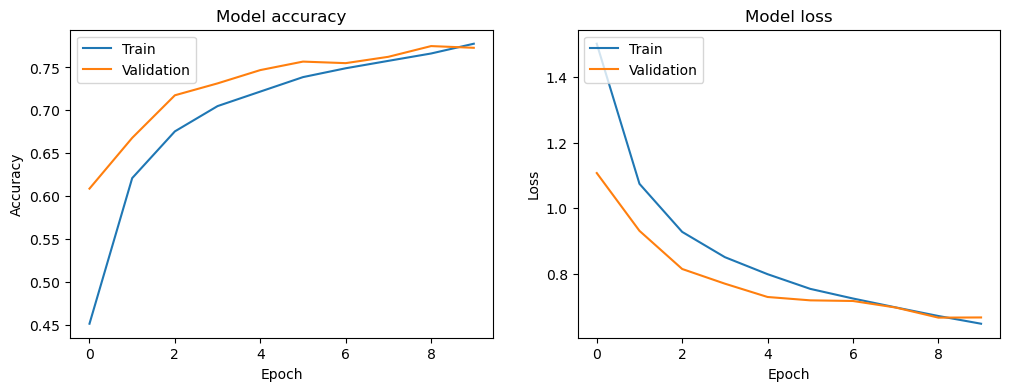

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

    airplane       0.78      0.83      0.80      1000
  automobile       0.89      0.87      0.88      1000
        bird       0.76      0.63      0.69      1000
         cat       0.56      0.65      0.60      1000
        deer       0.73      0.76      0.74      1000
         dog       0.72      0.60      0.66      1000
        frog       0.84      0.83      0.84      1000
       horse       0.83      0.79      0.81      1000
        ship       0.85      0.87      0.86      1000
       truck       0.79      0.89      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



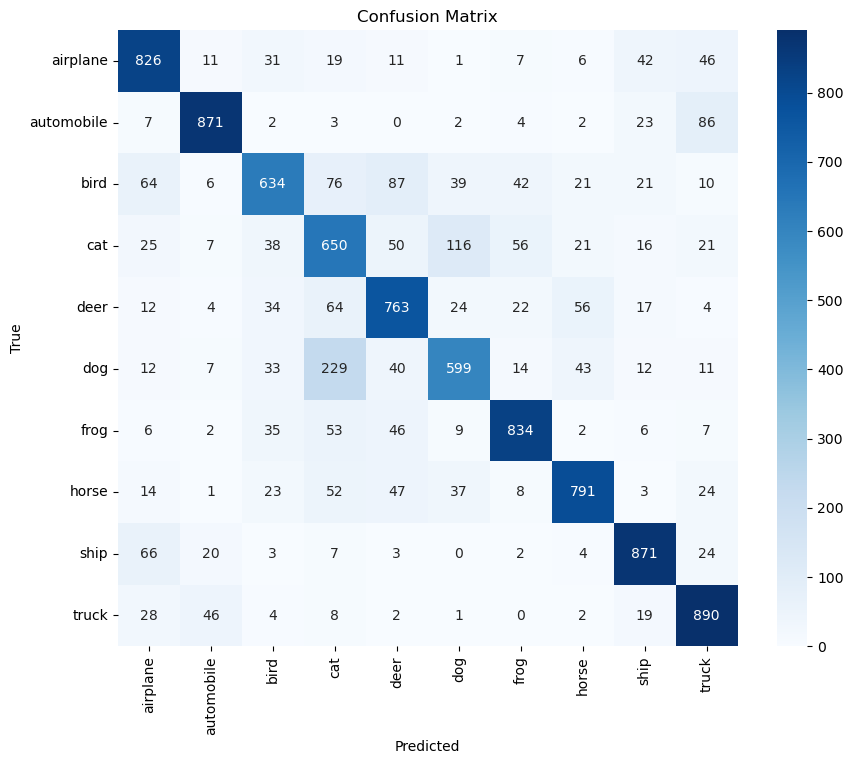

In [ ]:
model_drop = models.Sequential()
# Add padding to prevent image from becoming too small
model_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Dropout(0.15))

model_drop.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Dropout(0.15))

model_drop.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_drop.add(layers.MaxPooling2D((2, 2)))
model_drop.add(layers.Dropout(0.15))

model_drop.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_drop.add(layers.MaxPooling2D((2, 2), padding='same'))
model_drop.add(layers.Dropout(0.15))

model_drop.add(layers.Flatten())
model_drop.add(layers.Dense(128, activation='relu'))
model_drop.add(layers.Dropout(0.3))
model_drop.add(layers.Dense(10, activation='softmax'))

# Compile the model_drop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'

model_drop.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

ModelEval(model_drop, 10, 1)

Once again, accuracy improves to 77.2%

# Double the Conv2D Layer

Next thing to try is doubling the number of convolution layers. The data now goes through two convolution layers before going through pooling layer.

/Users/jayjoshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


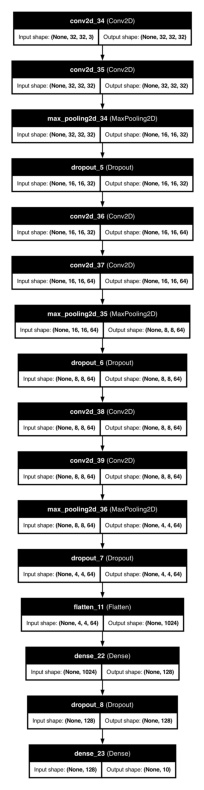

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 41ms/step - accuracy: 0.3329 - loss: 1.7957 - val_accuracy: 0.5773 - val_loss: 1.1759
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.5976 - loss: 1.1271 - val_accuracy: 0.6669 - val_loss: 0.9161
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.6722 - loss: 0.9273 - val_accuracy: 0.7165 - val_loss: 0.8124
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.7184 - loss: 0.8184 - val_accuracy: 0.7283 - val_loss: 0.7869
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7348 - loss: 0.7548 - val_accuracy: 0.7454 - val_loss: 0.7208
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7545 - loss: 0.7025 - val_accuracy: 0.7509 - val_loss: 0.7399
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.7672 - loss: 0.6676 - val_accuracy: 0.7610 - val_loss: 0.7123
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.7749 -

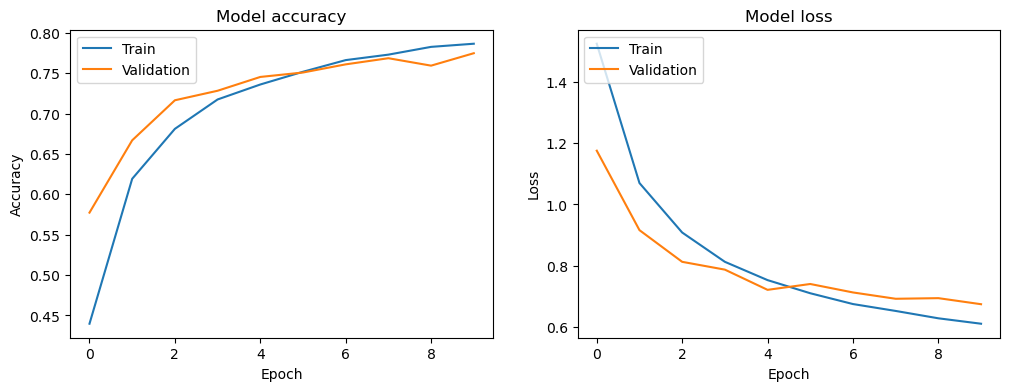

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

    airplane       0.80      0.79      0.79      1000
  automobile       0.90      0.87      0.88      1000
        bird       0.77      0.59      0.67      1000
         cat       0.57      0.65      0.61      1000
        deer       0.76      0.73      0.75      1000
         dog       0.72      0.69      0.70      1000
        frog       0.85      0.80      0.82      1000
       horse       0.75      0.85      0.80      1000
        ship       0.87      0.87      0.87      1000
       truck       0.79      0.90      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



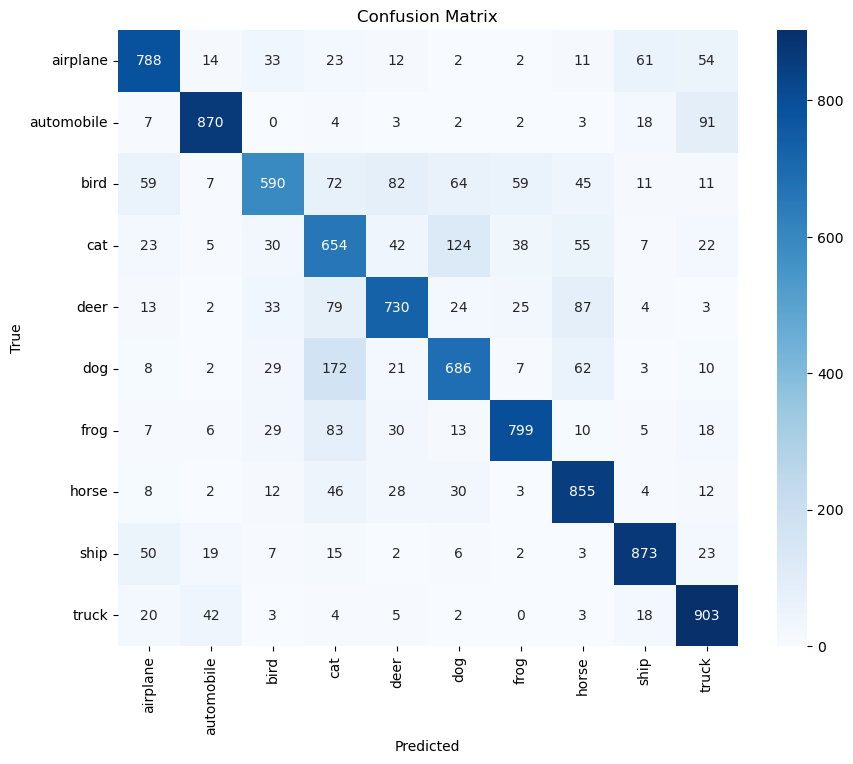

In [ ]:
model_d_conv = models.Sequential()

model_d_conv.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_d_conv.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_d_conv.add(layers.MaxPooling2D((2, 2)))
model_d_conv.add(layers.Dropout(0.15))

model_d_conv.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_d_conv.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_d_conv.add(layers.MaxPooling2D((2, 2)))
model_d_conv.add(layers.Dropout(0.15))

model_d_conv.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_d_conv.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_d_conv.add(layers.MaxPooling2D((2, 2)))
model_d_conv.add(layers.Dropout(0.15))

model_d_conv.add(layers.Flatten())
model_d_conv.add(layers.Dense(128, activation='relu'))
model_d_conv.add(layers.Dropout(0.3))
model_d_conv.add(layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'

model_d_conv.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

ModelEval(model_d_conv, 10, 1)

Accuracy goes up to 77.4% which is only a slight improvement, which does not seem worth the extra training time.

# Use sparse_categorical_crossentropy loss function

A different loss function is used here. Sparse Categorical Crossentropy is similar to Categorical Crossentropy, but it doesn't require labels that are one hot encoded. There is potential for improve in performance as it is less computationally expensive.


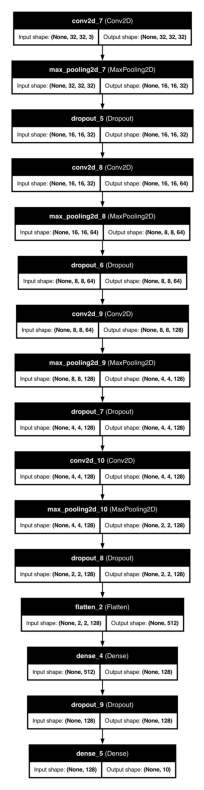

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.3427 - loss: 1.7639 - val_accuracy: 0.5634 - val_loss: 1.1993
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5972 - loss: 1.1374 - val_accuracy: 0.6674 - val_loss: 0.9520
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.6662 - loss: 0.9460 - val_accuracy: 0.7138 - val_loss: 0.8202
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.7029 - loss: 0.8527 - val_accuracy: 0.7331 - val_loss: 0.7722
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 598s 383ms/step - accuracy: 0.7253 - loss: 0.7970 - val_accuracy: 0.7357 - val_loss: 0.7899
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7396 - loss: 0.7477 - val_accuracy: 0.7493 - val_loss: 0.7435
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.7504 - loss: 0.7131 - val_accuracy: 0.7517 - val_loss: 0.7197
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.7631

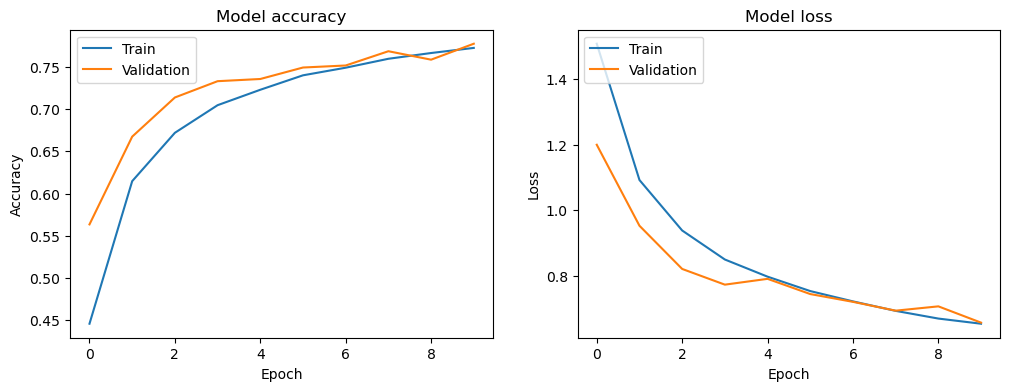

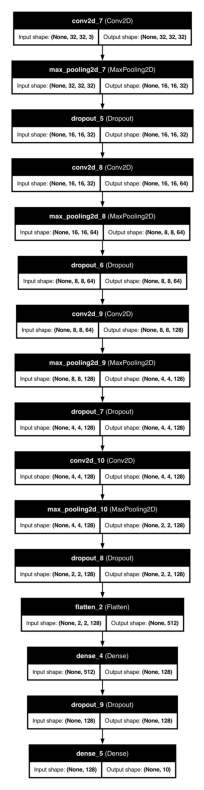

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7880 - loss: 0.6194 - val_accuracy: 0.7838 - val_loss: 0.6477
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.7902 - loss: 0.6044 - val_accuracy: 0.7685 - val_loss: 0.6940
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.7904 - loss: 0.6038 - val_accuracy: 0.7834 - val_loss: 0.6423
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7985 - loss: 0.5866 - val_accuracy: 0.7817 - val_loss: 0.6525
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.7986 - loss: 0.5759 - val_accuracy: 0.7799 - val_loss: 0.6568
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.8042 - loss: 0.5603 - val_accuracy: 0.7889 - val_loss: 0.6307
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8060 - loss: 0.5579

In [ ]:
modelsn = models.Sequential()

modelsn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
modelsn.add(layers.MaxPooling2D((2, 2)))
modelsn.add(layers.Dropout(0.15))

modelsn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
modelsn.add(layers.MaxPooling2D((2, 2)))
modelsn.add(layers.Dropout(0.15))

modelsn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
modelsn.add(layers.MaxPooling2D((2, 2)))
modelsn.add(layers.Dropout(0.15))

modelsn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
modelsn.add(layers.MaxPooling2D((2, 2), padding='same'))
modelsn.add(layers.Dropout(0.15))

modelsn.add(layers.Flatten())
modelsn.add(layers.Dense(128, activation='relu'))
modelsn.add(layers.Dropout(0.3))
modelsn.add(layers.Dense(10, activation='softmax'))

modelsn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

plot_and_display_model(modelsn, filename='modelsn', figsize=(10, 10))
test_loss, test_acc, history = evaluate_model(modelsn,
                                              train_images, train_labels,
                                              test_images, test_labels, 10)
plot_training_history(history)

ModelEval(modelsn, 10, 0)

In [ ]:
pip install nbconvert

This change gives an accuracy of 77.5% which is the highest.

Using a learning rate scheduler didn't improve performance significantly with this particular model.


Other changes like changing stride or dialating the kernel made the models worse as the images are already quite small, and those parameters are more effective with high resolution images.